### Naive Bayes Classifier

In [1]:
# importing the libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, roc_auc_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

In [2]:
# importing the dataset
dataset = pd.read_csv('seeds_dataset.txt', sep="\t", error_bad_lines=False, warn_bad_lines=True, header = None)
dataset.columns=['area','perimeter','compactness','length_kernel','width_kernel','asymmetry_coeff','length_of_kernel_groove','target']

b'Skipping line 8: expected 8 fields, saw 10\nSkipping line 36: expected 8 fields, saw 10\nSkipping line 61: expected 8 fields, saw 9\nSkipping line 69: expected 8 fields, saw 9\nSkipping line 107: expected 8 fields, saw 9\nSkipping line 136: expected 8 fields, saw 9\nSkipping line 170: expected 8 fields, saw 9\nSkipping line 171: expected 8 fields, saw 9\nSkipping line 173: expected 8 fields, saw 9\nSkipping line 202: expected 8 fields, saw 9\nSkipping line 204: expected 8 fields, saw 9\n'


In [3]:
dataset.head(5)

,area,perimeter,compactness,length_kernel,width_kernel,asymmetry_coeff,length_of_kernel_groove,target
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1


In [4]:
# Handling Outliers by replacing them with group mean
for column in dataset.columns[:-1]:
    for target in dataset["target"].unique():
        Q1 = dataset[column][dataset["target"] == target].quantile(0.25)
        Q3 = dataset[column][dataset["target"] == target].quantile(0.75)
        IQR = Q3 - Q1 #Interquartile range
        fence_low = Q1 - (1.5 * IQR)
        fence_high = Q3 + (1.5 * IQR)

        df2 = pd.DataFrame(dataset[dataset['target'] == target][column])

        for index in df2[df2[column] < fence_low].index:
            dataset.loc[index, column] = np.nan
        for index in df2[df2[column] > fence_high].index:
            dataset.loc[index, column] = np.nan 

group_mean = dataset.groupby("target").mean()
for column in dataset.columns[:-1]:
    for index in dataset[dataset[column].isna()].index:
        target = dataset.iloc[index,-1]
        dataset.loc[index, column] = group_mean[column][target]

In [5]:
data = dataset.copy()

# Separating the dataset into matrix of features and target'
X = dataset.iloc[:,:-1].values
y = dataset.iloc[:,-1].values

In [6]:
from sklearn.model_selection import train_test_split
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X, y, test_size=0.2, random_state=0)

### Base Model


In [7]:
%%time
from sklearn.model_selection import GridSearchCV

# Fitting the Classification Model
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()

nb_params = [{'var_smoothing':[1e-10, 1e-9, 1e-5, 1e-3, 1e-1]}]
nb_grid = GridSearchCV(nb, nb_params, cv=10)
nb_grid.fit(X_train_1, y_train_1)
nb_average_score = nb_grid.cv_results_['mean_test_score'].astype(float)
result = nb_grid.cv_results_
nb_grid.best_estimator_

Wall time: 56 ms


GaussianNB(var_smoothing=0.001)

In [8]:
nb_average_score

array([0.95   , 0.95   , 0.95   , 0.95625, 0.9375 ])

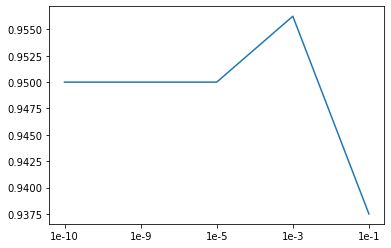

In [9]:
plt.figure()
sns.lineplot(x=["1e-10", "1e-9", "1e-5", "1e-3", "1e-1"], y=nb_average_score)
plt.show()

In [10]:
%%time
# Building model with optimal parameters
nb_1 = GaussianNB(var_smoothing=0.001)
nb_1.fit(X_train_1, y_train_1)

print("Training Set Evaluation")
print("Accuracy: ", round(100 * accuracy_score(y_train_1, nb_1.predict(X_train_1)), 2))
print("F1_score: ", round(f1_score(y_train_1, nb_1.predict(X_train_1), average = 'weighted'), 2))
print("AUC: ", round(roc_auc_score(y_train_1, nb_1.predict_proba(X_train_1), average = "macro", multi_class = "ovo"), 2))

Training Set Evaluation
Accuracy:  96.23
F1_score:  0.96
AUC:  1.0
Wall time: 8.96 ms


In [11]:
# Evaluating the model on the test set
nb_pred = nb_1.predict(X_test_1)

print("Test Set Evaluation")
print("Accuracy: ", round(100 * accuracy_score(y_test_1, nb_pred), 2))
print("F1_score: ", round(f1_score(y_test_1, nb_pred, average = 'weighted'), 2))
print("AUC: ", round(roc_auc_score(y_test_1, nb_1.predict_proba(X_test_1), average = "macro", multi_class = "ovo"), 2))

Test Set Evaluation
Accuracy:  95.0
F1_score:  0.95
AUC:  0.99


## <span style="color:blue"> Notes About Smoothing Parameter </span>
1e-3 is the best smoothing parameter with a training accuracy of 96.23% and test accuracy of 95%

A Gaussian curve can serve as a "low pass" filter, allowing only the samples close to its mean to "pass." In the context of Naive Bayes, assuming a Gaussian distribution is essentially giving more weights to the samples closer to the distribution mean. This might filter out some values that we want to "pass".

The variable, var_smoothing, artificially adds a user-defined value to the distribution's variance (whose default value is derived from the training data set). This essentially widens (or "smooths") the curve and accounts for more samples that are further away from the distribution mean.

Tuning this parameter, will also modify the variance in a way that will give the best accuracy

### Improving the model computation by removing multicollinear features 

In [12]:
dataset2 = data[['area', 'compactness' , 'width_kernel', 'asymmetry_coeff', 'length_of_kernel_groove', 'target']]

# Separating the dataset into matrix of features and target'
X = dataset2.iloc[:,:-1].values
y = dataset2.iloc[:,-1].values

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [14]:
%%time

# Fitting the Classification Model
nb_grid.fit(X_train, y_train)
nb_average_score = nb_grid.cv_results_['mean_test_score'].astype(float)
result = nb_grid.cv_results_
nb_grid.best_estimator_

Wall time: 55 ms


GaussianNB(var_smoothing=0.001)

In [15]:
nb_average_score

array([0.94375, 0.94375, 0.94375, 0.9625 , 0.94375])

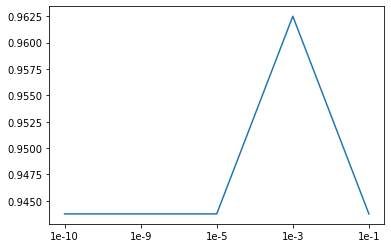

In [16]:
plt.figure()
sns.lineplot(x=["1e-10", "1e-9", "1e-5", "1e-3", "1e-1"], y=nb_average_score)
plt.show()

In [17]:
%%time
# Building model with optimal parameters
nb = GaussianNB(var_smoothing=0.001)
nb.fit(X_train, y_train)

print("Training Set Evaluation")
print("Accuracy: ", round(100 * accuracy_score(y_train, nb.predict(X_train)), 2))
print("F1_score: ", round(f1_score(y_train, nb.predict(X_train), average = 'weighted'), 2))
print("AUC: ", round(roc_auc_score(y_train, nb.predict_proba(X_train), average = "macro", multi_class = "ovo"), 2))

Training Set Evaluation
Accuracy:  96.86
F1_score:  0.97
AUC:  1.0
Wall time: 10 ms


In [18]:
# Evaluating the model on the test set
nb_pred = nb.predict(X_test)

print("Test Set Evaluation")
print("Accuracy: ", round(100 * accuracy_score(y_test, nb_pred), 2))
print("F1_score: ", round(f1_score(y_test, nb_pred, average = 'weighted'), 2))
print("AUC: ", round(roc_auc_score(y_test, nb.predict_proba(X_test), average = "macro", multi_class = "ovo"), 2))

Test Set Evaluation
Accuracy:  92.5
F1_score:  0.92
AUC:  0.99


### <span style="color:blue">Effect of removing multicolinear features</span>

- The training set accuracy increased from 96.23% to 96.86%.
- The test set accuracy reduced from 95% to 92.5%.

### Improving the model by feature scaling

##### Standard Scaler

In [19]:
X_scaler = StandardScaler()
X_SS = X_scaler.fit_transform(X_train)
X_SS_test = X_scaler.transform(X_test)
nb_grid.fit(X_SS, y_train)
nb_average_score = nb_grid.cv_results_['mean_test_score'].astype(float)
result = nb_grid.cv_results_
nb_grid.best_estimator_

GaussianNB(var_smoothing=0.1)

In [20]:
nb_average_score

array([0.94375, 0.94375, 0.94375, 0.94375, 0.95   ])

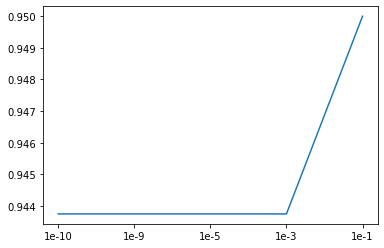

In [21]:
plt.figure()
sns.lineplot(x=["1e-10", "1e-9", "1e-5", "1e-3", "1e-1"], y=nb_average_score)
plt.show()

In [22]:
%%time
# Building model with optimal parameters
nb = GaussianNB(var_smoothing=0.1)
nb.fit(X_SS, y_train)

print("Training Set Evaluation")
print("Accuracy: ", round(100 * accuracy_score(y_train, nb.predict(X_SS)), 2))
print("F1_score: ", round(f1_score(y_train, nb.predict(X_SS), average = 'weighted'), 2))
print("AUC: ", round(roc_auc_score(y_train, nb.predict_proba(X_SS), average = "macro", multi_class = "ovo"), 2))

Training Set Evaluation
Accuracy:  95.6
F1_score:  0.96
AUC:  1.0
Wall time: 7.99 ms


In [23]:
# Evaluating the model on the test set
nb_pred = nb.predict(X_SS_test)

print("Test Set Evaluation")
print("Accuracy: ", round(100 * accuracy_score(y_test, nb_pred), 2))
print("F1_score: ", round(f1_score(y_test, nb_pred, average = 'weighted'), 2))
print("AUC: ", round(roc_auc_score(y_test, nb.predict_proba(X_SS_test), average = "macro", multi_class = "ovo"), 2))

Test Set Evaluation
Accuracy:  90.0
F1_score:  0.9
AUC:  0.99


##### MinMax Scaler

In [24]:
X_scaler = MinMaxScaler()
X_MMS = X_scaler.fit_transform(X_train)
X_MMS_test = X_scaler.transform(X_test)
nb_grid.fit(X_MMS, y_train)
nb_average_score = nb_grid.cv_results_['mean_test_score'].astype(float)
result = nb_grid.cv_results_
nb_grid.best_estimator_

GaussianNB(var_smoothing=0.1)

In [25]:
nb_average_score

array([0.94375, 0.94375, 0.94375, 0.94375, 0.95   ])

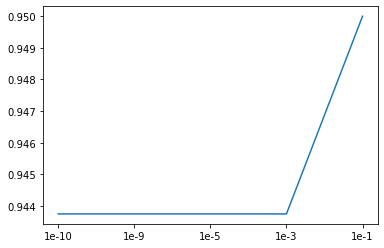

In [26]:
plt.figure()
sns.lineplot(x=["1e-10", "1e-9", "1e-5", "1e-3", "1e-1"], y=nb_average_score)
plt.show()

In [27]:
%%time
# Building model with optimal parameters
nb = GaussianNB(var_smoothing=0.1)
nb.fit(X_MMS, y_train)

print("Training Set Evaluation")
print("Accuracy: ", round(100 * accuracy_score(y_train, nb.predict(X_MMS)), 2))
print("F1_score: ", round(f1_score(y_train, nb.predict(X_MMS), average = 'weighted'), 2))
print("AUC: ", round(roc_auc_score(y_train, nb.predict_proba(X_MMS), average = "macro", multi_class = "ovo"), 2))

Training Set Evaluation
Accuracy:  94.97
F1_score:  0.95
AUC:  0.99
Wall time: 7.95 ms


In [28]:
# Evaluating the model on the test set
nb_pred = nb.predict(X_MMS_test)

print("Test Set Evaluation")
print("Accuracy: ", round(100 * accuracy_score(y_test, nb_pred), 2))
print("F1_score: ", round(f1_score(y_test, nb_pred, average = 'weighted'), 2))
print("AUC: ", round(roc_auc_score(y_test, nb.predict_proba(X_MMS_test), average = "macro", multi_class = "ovo"), 2))

Test Set Evaluation
Accuracy:  92.5
F1_score:  0.93
AUC:  0.99


##### Robust Scaler

In [29]:
X_scaler = RobustScaler()
X_RS = X_scaler.fit_transform(X_train)
X_RS_test = X_scaler.transform(X_test)
nb_grid.fit(X_RS, y_train)
nb_average_score = nb_grid.cv_results_['mean_test_score'].astype(float)
result = nb_grid.cv_results_
nb_grid.best_estimator_

GaussianNB(var_smoothing=0.1)

In [30]:
nb_average_score

array([0.94375, 0.94375, 0.94375, 0.94375, 0.95   ])

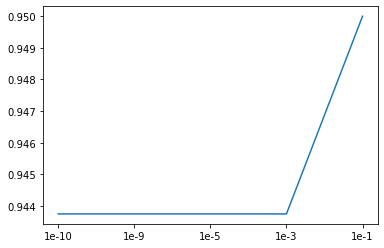

In [31]:
plt.figure()
sns.lineplot(x=["1e-10", "1e-9", "1e-5", "1e-3", "1e-1"], y=nb_average_score)
plt.show()

In [32]:
%%time
# Building model with optimal parameters
nb = GaussianNB(var_smoothing=0.1)
nb.fit(X_RS, y_train)

print("Training Set Evaluation")
print("Accuracy: ", round(100 * accuracy_score(y_train, nb.predict(X_RS)), 2))
print("F1_score: ", round(f1_score(y_train, nb.predict(X_RS), average = 'weighted'), 2))
print("AUC: ", round(roc_auc_score(y_train, nb.predict_proba(X_RS), average = "macro", multi_class = "ovo"), 2))

Training Set Evaluation
Accuracy:  96.23
F1_score:  0.96
AUC:  0.99
Wall time: 9.94 ms


In [33]:
# Evaluating the model on the test set
nb_pred = nb.predict(X_RS_test)

print("Test Set Evaluation")
print("Accuracy: ", round(100 * accuracy_score(y_test, nb_pred), 2))
print("F1_score: ", round(f1_score(y_test, nb_pred, average = 'weighted'), 2))
print("AUC: ", round(roc_auc_score(y_test, nb.predict_proba(X_RS_test), average = "macro", multi_class = "ovo"), 2))

Test Set Evaluation
Accuracy:  90.0
F1_score:  0.9
AUC:  0.99


### <span style="color:blue"> Notes About Feature Scaling on Naive Bayes </span>

Effects of Scaling on Training Set

| Scaling Method |  Accuracy | F1 Score | AUC |
| --- | --- | --- | --- |
| Standard Scaler | 95.6 | 0.96 | 1 |
| MinMax Scaler | 94.97 | 0.95 | 0.99 |
| Robust Scaler | 96.23 | 0.96 | 0.99 |
| No Scaler | 96.86 | 0.97 | 1 |

Effects of Scaling on Test Set

| Scaling Method |  Accuracy | F1 Score | AUC |
| --- | --- | --- | --- |
| Standard Scaler | 90 | 0.9 | 0.99 |
| MinMax Scaler | 92.5 | 0.93 | 0.99 |
| Robust Scaler | 90 | 0.9 | 0.99 |
| No Scaler | 92.5 | 0.92 | 0.99 |

The Naive Bayes classifier performs better without feature scaling. Naive Bayes is not very sensitive to distance between values like KNN, so we did not expect much improvement from Feature Scaling.

## <span style="color:blue">CM6 (Wheat Seeds Dataset) </span>

In [41]:
print("Feature Means per class: \n", np.round(nb_1.theta_, 2))

Feature Means per class: 
 [[14.34 14.34  0.88  5.53  3.24  2.73  5.08]
 [18.36 16.15  0.88  6.17  3.68  3.67  6.03]
 [11.88 13.26  0.85  5.24  2.85  4.66  5.12]]


In [42]:
print("Feature Variance per class: \n", np.round(nb_1.sigma_, 3))

Feature Variance per class: 
 [[0.945 0.249 0.009 0.051 0.036 1.185 0.075]
 [2.089 0.366 0.009 0.062 0.046 1.424 0.054]
 [0.512 0.131 0.009 0.027 0.029 0.994 0.036]]


In [43]:
print("Class Priors: \n",  np.round(nb_1.class_prior_, 3))

Class Priors: 
 [0.327 0.365 0.308]


##### Learned Parameters and Naive Bayes
The Feature Means and Variances best describe the classifier

##### <span style="color:blue">Perfomance of Decision Tree vs Naive Bayes</span>

|Accuracy|Decision Tree | Naive Bayes | 
| --- | --- | --- |
| Training  Accuracy | 100 | 96.23 |
| Test Accuracy | 92.5 | 95 | 
| **Wall Time | 364ms | 4.59ms |

Naive Bayes has a slightly higher Test Accuracy and is much faster than Decision Tree. Looking at the difference between the training accuracy and test accuracy of the Decision Tree we can also infer that the Decision Tree is more likely to overfit.

In [37]:
from sklearn.inspection import permutation_importance
r = permutation_importance(nb_1, X_train_1, y_train_1, n_repeats=30, random_state=0)

for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{dataset.columns[i]:<8}  "
              f" Mean: + {r.importances_mean[i]:.3f}  "
               f" STD: +/- {r.importances_std[i]:.3f}")

area       Mean: + 0.185   STD: +/- 0.025
perimeter   Mean: + 0.156   STD: +/- 0.023
length_of_kernel_groove   Mean: + 0.078   STD: +/- 0.019
length_kernel   Mean: + 0.077   STD: +/- 0.019
width_kernel   Mean: + 0.075   STD: +/- 0.016
asymmetry_coeff   Mean: + 0.040   STD: +/- 0.011


#### <span style="color:blue"> Relation to Decision Tree Splitting Rules </span>
The most important features learned by the Naive Bayes Classifier; Area, length of Kernel groove, width Kernel and Asymmetry Coefficient were the features used in all the splitting rules of the Decision Tree. 
